In [1]:
from Scratch import metadata_loader
import numpy as np
from tqdm import tqdm

DEVICE = "ibm_torino"
LOGICAL = str(0)
XBASIS = False
ROUNDS = 50

state = "X" if XBASIS else "Z"
state += LOGICAL
print(f"state = {state}")


# Load the metadata
md = metadata_loader(True, True)
md = md[md["job_status"] == "JobStatus.DONE"]
md = md[md["code"] == "RepetitionCodeCircuit"]
md = md[md["descr"] == 'subset RepCodes']
md = md.dropna(subset=["rounds"])
md = md[md["meas_level"] == 1]
md['rounds'] = md['rounds'].astype(int)
md['distance'] = md['distance'].astype(int)

md = md[md["backend_name"] == DEVICE]
md = md[md["logical"] == LOGICAL]
md = md[md["xbasis"] == XBASIS]
md = md[md["rounds"] == ROUNDS]

# md = md[0:1]
print("shape:", md.shape)
md[:2]


state = Z0
shape: (40, 18)


,creation_date,notebook_name,backend_name,job_id,tags,meas_level,shots,num_qubits,job_status,execution_date,code,distance,rounds,logical,descr,resets,xbasis,path_info
5483,2024-03-24 15:59:50.864000+01:00,Torino_RepCodes_jobs,ibm_torino,cr03zsqdvs8g008j7ra0,"[Subset 56, 50 rounds, 0 log, xbasis=False]",1.0,1398.0,NaN,JobStatus.DONE,2024-03-24 16:51:12.990431+01:00,RepetitionCodeCircuit,56,50,0,subset RepCodes,NaN,False,"{'mean_gate_error': 0.006452510204489, 'min_ga..."
5482,2024-03-24 15:59:44.592000+01:00,Torino_RepCodes_jobs,ibm_torino,cr03zr7k5z700081s2tg,"[Subset 56, 50 rounds, 0 log, xbasis=False]",1.0,1398.0,NaN,JobStatus.DONE,2024-03-24 16:50:44.865382+01:00,RepetitionCodeCircuit,56,50,0,subset RepCodes,NaN,False,"{'mean_gate_error': 0.006452510204489, 'min_ga..."


In [2]:
from result_saver import SaverProvider

provider = SaverProvider()

In [3]:
# job_id = "cr03zsqdvs8g008j7ra0" # Take the first torino job
# job_id = "cr03zr7k5z700081s2tg"

job_id = md.iloc[0]["job_id"]
job = provider.retrieve_job(job_id) 

execution_date = job.result().date
memory = job.result().get_memory()

# Needed decoding objects

In [4]:
import numpy as np

_RESETS = False
SOFT_MUL = 0.5
T = md.iloc[0]["rounds"]
d = md.iloc[0]["distance"]

shots = md.iloc[0]["shots"]

rel_error = 1

# KDE BANDWIDTHS
lin = [0.1, 0.7, 30]
num_points = 51
bandwidths = np.linspace(lin[0], lin[1], lin[2])

In [5]:
from soft_info import get_noise_dict_from_backend, get_avgs_from_dict, get_repcode_IQ_map
from soft_info import RepetitionCodeStimCircuit, inv_qubit_mapping
from soft_info import get_cols_to_keep, generate_subsets_with_center, get_subsample_layout
from Scratch import load_calibration_memory
import cpp_soft_info

noise_dict = get_noise_dict_from_backend(provider, DEVICE, date = execution_date)
all_memories = load_calibration_memory(provider, tobecalib_backend=DEVICE, other_date=execution_date)
kde_dict = cpp_soft_info.get_KDEs(all_memories, bandwidths, relError=rel_error, absError=-1, num_points=51)

14:01:56 Warning: Could not get two gate error of ECR due to 'Could not find the desired property for ecr', taking CX instead.. IN FILE: /Users/mha/My_Drive/Desktop/Studium/Physik/MSc/Semester_3/IBM/IBM_GIT/Soft-Info/src/soft_info/Hardware/backend_noise.py, LINE: 67
14:01:56 Warning: Could not get two gate error of CX due to 'Could not find the desired property for cx', taking 0.5 instead.. IN FILE: /Users/mha/My_Drive/Desktop/Studium/Physik/MSc/Semester_3/IBM/IBM_GIT/Soft-Info/src/soft_info/Hardware/backend_noise.py, LINE: 71
Found jobs for backend ibm_torino with closest execution date 2024-03-23 11:10:08.069460+00:00.


In [6]:
print(all_memories[0]["mmr_0"].shape)

(30075,)


In [7]:
for i in range(127):
    print(i, kde_dict[i].bestBandwidth)

0 0.24482758620689657
1 0.16206896551724137
2 0.22413793103448276
3 0.20344827586206898
4 0.3896551724137931
5 0.18275862068965518
6 0.24482758620689657
7 0.3275862068965517
8 0.24482758620689657
9 0.1413793103448276
10 0.20344827586206898
11 0.24482758620689657
12 0.2655172413793103
13 0.20344827586206898
14 0.22413793103448276
15 0.24482758620689657
16 0.20344827586206898
17 0.1206896551724138
18 0.22413793103448276
19 0.20344827586206898
20 0.24482758620689657
21 0.34827586206896555
22 0.24482758620689657
23 0.20344827586206898
24 0.28620689655172415
25 0.18275862068965518
26 0.28620689655172415
27 0.22413793103448276
28 0.16206896551724137
29 0.22413793103448276
30 0.22413793103448276
31 0.24482758620689657
32 0.2655172413793103
33 0.30689655172413793
34 0.20344827586206898
35 0.18275862068965518
36 0.1206896551724138
37 0.2655172413793103
38 0.43103448275862066
39 0.2655172413793103
40 0.22413793103448276
41 0.24482758620689657
42 0.20344827586206898
43 0.28620689655172415
44 0.22

In [8]:
from datetime import datetime

# Get the layout of the last job (same as previous)
layout_des = job.deserialize_layout(job.initial_layouts()[0]) # only 1 layout
link_qubits = list(layout_des['link_qubit'].values())
code_qubits = list(layout_des['code_qubit'].values())

# Get the pSoft and countMat matrices
big_layout = link_qubits + code_qubits
inverted_q_map = inv_qubit_mapping(get_repcode_IQ_map(big_layout, synd_rounds=T))

print(f"Starting to get pSoft and countMat at {datetime.now()}")
pSoft, countMat = cpp_soft_info.iqConvertor(memory, inverted_q_map, kde_dict, rel_error, -1)
print(f"Finished getting pSoft and countMat at {datetime.now()}")

Starting to get pSoft and countMat at 2024-03-27 14:03:25.558286
Finished getting pSoft and countMat at 2024-03-27 14:03:47.073304


In [9]:
print(pSoft.shape)
print(f"mean pSoft: {np.mean(pSoft)}, max pSoft: {np.max(pSoft)}, min pSoft: {np.min(pSoft)}")
print(f"unique values: {np.unique(pSoft)}")

print() 

twobitpSoft = cpp_soft_info.quantizeMatrixVectorized(pSoft, 2)
print(twobitpSoft.shape)
print(f"mean 2bpS: {np.mean(twobitpSoft)}, max 2bpS: {np.max(twobitpSoft)}, min 2bpS: {np.min(twobitpSoft)}")
print(f"unique values: {np.unique(twobitpSoft)}")

print()

twobitpSoft_ews = cpp_soft_info.quantizeMatrixEntrywise(pSoft, 2)
print(twobitpSoft_ews.shape)
print(f"mean 2bpS ews: {np.mean(twobitpSoft_ews)}, max 2bpS ews: {np.max(twobitpSoft_ews)}, min 2bpS ews: {np.min(twobitpSoft_ews)}")
print(f"unique values: {np.unique(twobitpSoft_ews)}")

(1398, 2806)
mean pSoft: 0.0663199280795556, max pSoft: 0.5, min pSoft: 4.519292629558095e-15
unique values: [4.51929263e-15 4.53480485e-15 4.56733686e-15 ... 4.99998652e-01
 4.99999922e-01 5.00000000e-01]

(1398, 2806)
mean 2bpS: 0.04680535884172175, max 2bpS: 0.5, min 2bpS: 0.0
unique values: [0.         0.16666667 0.33333333 0.5       ]

(1398, 2806)
mean 2bpS ews: 0.08371609681685577, max 2bpS ews: 0.5, min 2bpS ews: 0.0625
unique values: [0.0625 0.1875 0.3125 0.4375 0.5   ]


# Decoding

In [10]:
distances = range(3, d+1, 4)
print(list(distances))

nBits_ls = range(1, 20, 1)
print(list(nBits_ls))

[3, 7, 11, 15, 19, 23, 27, 31, 35, 39, 43, 47, 51, 55]
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]


In [11]:
from tqdm import tqdm

soft = []
hard = []
for D_NEW in (distances):
    # if D_NEW != 15:
    #     continue

    subsets = generate_subsets_with_center(d, D_NEW)
    n_subsets = len(subsets)

    errs_soft = []
    errs_hard = []
    for subset in subsets:

        cols_to_keep = get_cols_to_keep(subset, T, d)
        pSoft_sub = pSoft[:, cols_to_keep]
        countMat_sub = countMat[:, cols_to_keep]

        # Get the layout
        layout = get_subsample_layout(subset, link_qubits, code_qubits)
        qubit_mapping = get_repcode_IQ_map(layout, synd_rounds=T)

        # Get the noise avgs
        avgs = get_avgs_from_dict(noise_dict, layout)
        noise_list = [avgs["two_gate"], avgs["single_gate"], avgs["t1_err"], avgs["t2_err"]]
        readout = avgs["readout"]
        # noise_list += [readout, readout*(1-SOFT_MUL), readout*SOFT_MUL]
        # noise_list += [readout, readout*(1-SOFT_MUL), np.mean(pSoft_sub)]
        noise_list += [readout, readout*(1-SOFT_MUL), np.mean(pSoft)] 

        # Stim model
        subsampling = (D_NEW != d)
        code = RepetitionCodeStimCircuit(D_NEW, T, xbasis=XBASIS, resets=_RESETS, 
                                        noise_list=noise_list, subsampling=subsampling)
        model = code.circuits[LOGICAL].detector_error_model(decompose_errors=False)  


        # pSoft_trunc = cpp_soft_info.quantizeMatrixVectorized(pSoft_sub, 2) 
        pSoft_trunc = pSoft_sub

        result_soft, result_hard = cpp_soft_info.decodeConvertorAll(model, countMat_sub, pSoft_trunc,
                                                    T, int(LOGICAL), _RESETS)
        
        result_soft = cpp_soft_info.decodeConvertorSoft(model, countMat_sub, pSoft_trunc,
                                                    T, int(LOGICAL), _RESETS, False)
        errs_soft.append(result_soft.num_errors)
        errs_hard.append(result_hard.num_errors)


        # errs_per_nBits = []
        # result = cpp_soft_info.decodeConvertorSoft(model, countMat_sub, pSoft_sub,
        #                                                                         T, int(LOGICAL), _RESETS, False)
        # errs_per_nBits.append(result.num_errors)
        # for nBits in tqdm(nBits_ls):
        #     pSoft_trunc = cpp_soft_info.quantizeMatrixVectorized(pSoft_sub, nBits)
        #     # pSoft_trunc = cpp_soft_info.quantizeMatrixEntrywise(pSoft_sub, nBits)
        #     result = cpp_soft_info.decodeConvertorSoft(model, countMat_sub, pSoft_trunc,
        #                                                                         T, int(LOGICAL), _RESETS, False)
            # errs_per_nBits.append(result.num_errors)
        # print(errs_per_nBits)
    print(f"d = {D_NEW}, err_rate soft: {np.sum(errs_soft)/(shots*n_subsets)}, err_rate hard: {np.sum(errs_hard)/(shots*n_subsets)}")
    soft.append(np.sum(errs_soft)/(shots*n_subsets))
    hard.append(np.sum(errs_hard)/(shots*n_subsets))
# print(errs_per_nBits)

d = 3, err_rate soft: 0.1892754956059677, err_rate hard: 0.17369200899243817
d = 7, err_rate soft: 0.11373390557939914, err_rate hard: 0.09334763948497854
d = 11, err_rate soft: 0.06509298998569385, err_rate hard: 0.04911778731521221
d = 15, err_rate soft: 0.04703147353361946, err_rate hard: 0.031831187410586555
d = 19, err_rate soft: 0.0330829756795422, err_rate hard: 0.017703862660944206
d = 23, err_rate soft: 0.018359561278016214, err_rate hard: 0.010014306151645207
d = 27, err_rate soft: 0.010968049594659036, err_rate hard: 0.007868383404864092
d = 31, err_rate soft: 0.004649499284692418, err_rate hard: 0.00357653791130186
d = 35, err_rate soft: 0.003934191702432046, err_rate hard: 0.00357653791130186
d = 39, err_rate soft: 0.002145922746781116, err_rate hard: 0.002145922746781116
d = 43, err_rate soft: 0.00178826895565093, err_rate hard: 0.000357653791130186
d = 47, err_rate soft: 0.000715307582260372, err_rate hard: 0.000357653791130186
d = 51, err_rate soft: 0.0, err_rate hard: 

([<matplotlib.axis.XTick at 0x36d281410>,
 [Text(3, 0, '3'),
  Text(7, 0, '7'),
  Text(11, 0, '11'),
  Text(15, 0, '15'),
  Text(19, 0, '19'),
  Text(23, 0, '23'),
  Text(27, 0, '27'),
  Text(31, 0, '31'),
  Text(35, 0, '35'),
  Text(39, 0, '39'),
  Text(43, 0, '43'),
  Text(47, 0, '47'),
  Text(51, 0, '51'),
  Text(55, 0, '55')])

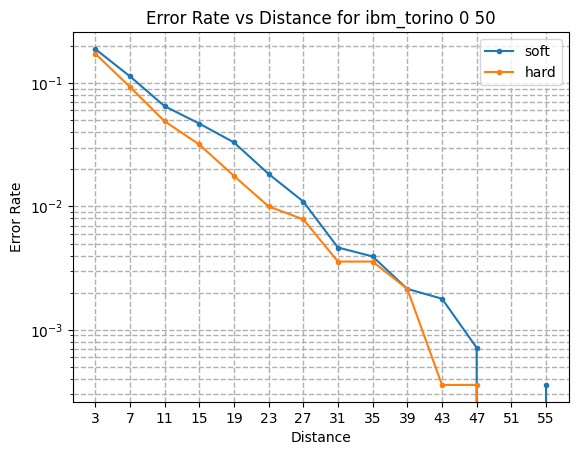

In [12]:
import matplotlib.pyplot as plt

plt.plot(distances, soft, label="soft", marker="o", markersize=3)
plt.plot(distances, hard, label="hard", marker="o", markersize=3)
plt.xlabel("Distance")
plt.ylabel("Error Rate")
plt.yscale("log")
plt.title(f"Error Rate vs Distance for {DEVICE} {LOGICAL} {ROUNDS}")
plt.legend()
plt.grid(True, which="both", linestyle='--', linewidth=1)
plt.xticks(distances)